# PCA vs AUTOENCODERS

- Compare the performance of a Linear Autoencoder with Principal Component Analysis (PCA) for dimensionality reduction on any medical dataset.

- ***Ayushmaan Das (E0121037)***

<hr>

### Importing the Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

<hr>

### Fetching the dataset from Kaggle and organizing

In [3]:
!curl -L -o covid19-radiography-database.zip\
  https://www.kaggle.com/api/v1/datasets/download/tawsifurrahman/covid19-radiography-database

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  778M  100  778M    0     0   102M      0  0:00:07  0:00:07 --:--:-- 81.1M


In [ ]:
!unzip covid19-radiography-database.zip

- Creating a smaller subset of the dataset (due to lack of resources)

In [8]:
import os
from tensorflow.keras.preprocessing import image
def load_subset_of_images(folder, num_images=500, image_size=(128, 128)):
    images = []
    filenames = os.listdir(folder)
    selected_files = np.random.choice(filenames, size=num_images, replace=False)
    for filename in selected_files:
        img_path = os.path.join(folder, filename)
        try:
            img = image.load_img(img_path, target_size=image_size)
            img_array = image.img_to_array(img)
            images.append(img_array)
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    return np.array(images)

<hr>

### Data Preparation and Preprocessing

In [9]:
dataset_path = "Covid-19 Data"
image_size = (128, 128)
batch_size = 32

In [15]:
num_images_per_class = 500
covid_images = load_subset_of_images(os.path.join(dataset_path, 'COVID'), num_images=num_images_per_class)
normal_images = load_subset_of_images(os.path.join(dataset_path, 'Normal'), num_images=num_images_per_class)

In [16]:
covid_images = covid_images / 255.0
normal_images = normal_images / 255.0

In [17]:
X_data = np.concatenate([covid_images, normal_images], axis=0)

In [18]:
len(X_data)

1000

<hr>

### Principal Component Analysis (PCA) for Dimensionality Reduction

- Reshaping our data

In [19]:
X_data_reshaped = X_data.reshape(X_data.shape[0], -1)

- Perform Dimensionality Reduction using PCA

In [20]:
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_pca = pca.fit_transform(X_data_reshaped)

In [21]:
print("Original shape:", X_data_reshaped.shape)
print("PCA shape:", X_pca.shape)

Original shape: (1000, 49152)
PCA shape: (1000, 132)


- Performing Reconstruction using reduced dimensionality

In [22]:
X_reconstructed = pca.inverse_transform(X_pca)

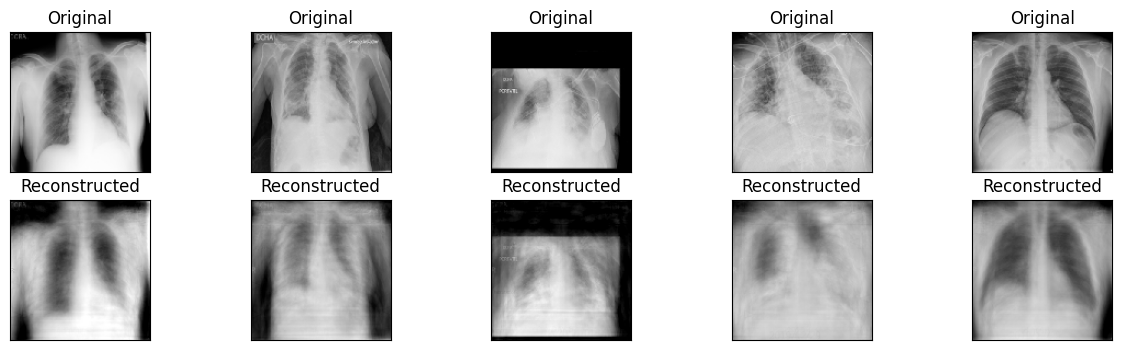

In [26]:
X_reconstructed_images = X_reconstructed.reshape(X_data.shape)

n = 5
plt.figure(figsize=(15, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_data[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_reconstructed_images[i])
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

- Checking the stats of our reduction

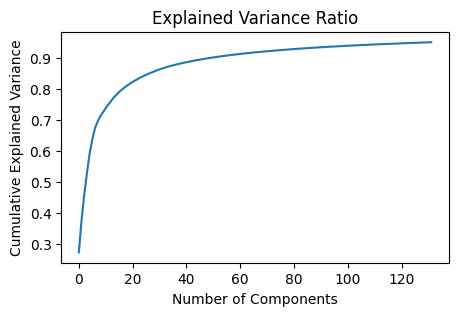

In [24]:
plt.figure(figsize=(5, 3))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio')
plt.show()

<hr>

### Linear Autoencoder

- Defining the layers of the model

In [27]:
input_img = Input(shape=(128, 128, 3))
flat_img = Flatten()(input_img)
encoded = Dense(128, activation='linear')(flat_img)  # Bottleneck layer
decoded = Dense(128 * 128 * 3, activation='sigmoid')(encoded)
decoded_img = Reshape((128, 128, 3))(decoded)

- Model compilation and Training

In [29]:
autoencoder = Model(input_img, decoded_img)
autoencoder.compile(optimizer='adam', loss='mse')

In [30]:
autoencoder.fit(X_data, X_data, epochs=10, batch_size=32, shuffle=True, validation_split=0.2)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0602 - val_loss: 0.0369
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0333 - val_loss: 0.0248
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0241 - val_loss: 0.0208
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0223 - val_loss: 0.0171
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0183 - val_loss: 0.0168
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0169 - val_loss: 0.0181
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0187 - val_loss: 0.0152
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0154 - val_loss: 0.0150
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0151 - val_loss: 0.0145
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0139 - val_loss: 0.0135


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


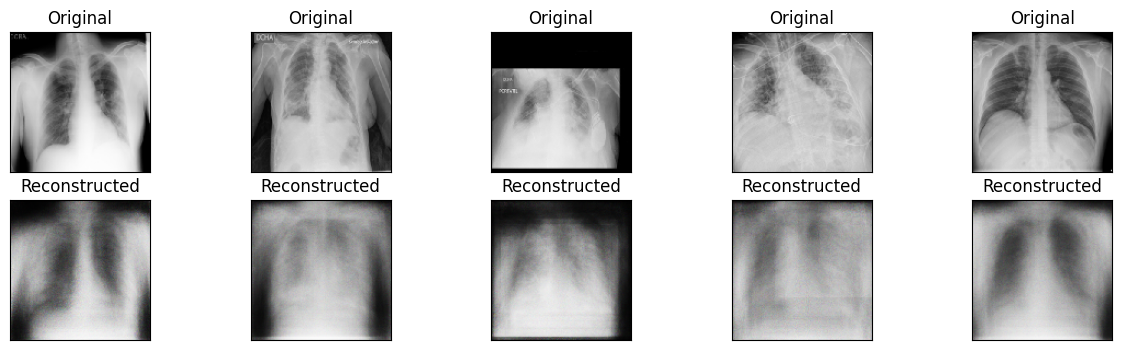

In [32]:
X_reconstructed_autoencoder = autoencoder.predict(X_data)

n = 5
plt.figure(figsize=(15, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_data[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_reconstructed_autoencoder[i])
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

<hr>

### Comparing the Reconstructions (PCS vs Autoencoders)

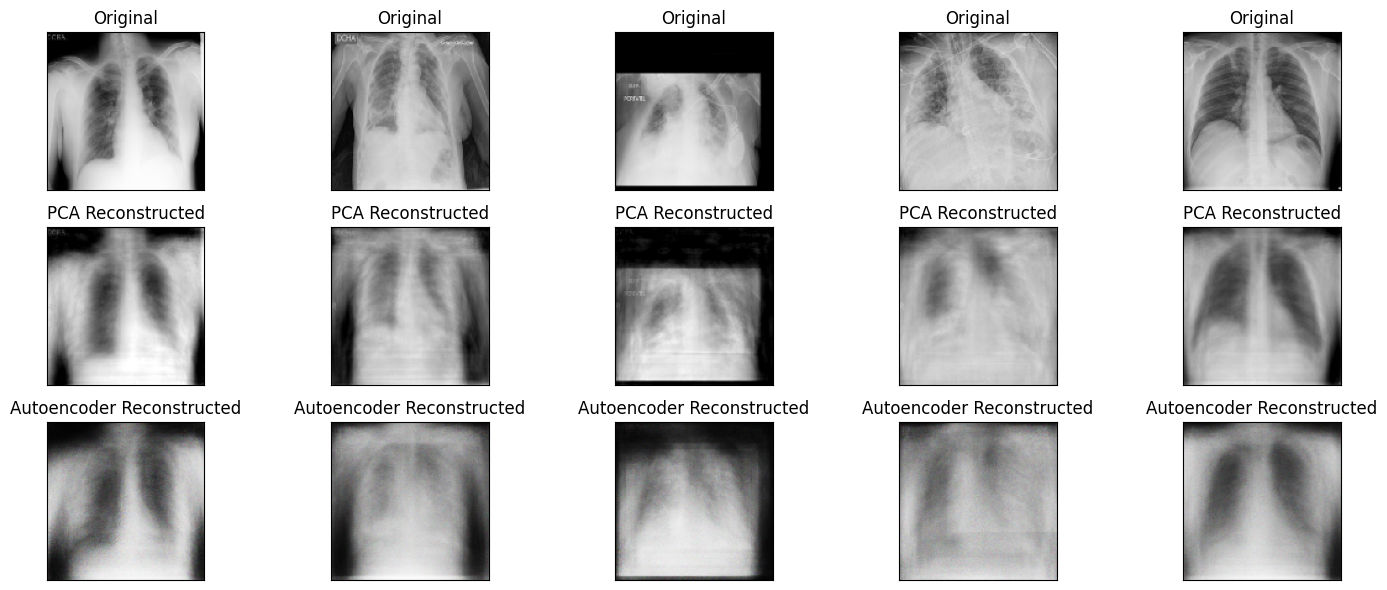

In [33]:
n = 5
plt.figure(figsize=(15, 6))
for i in range(n):
    # Original Images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_data[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # PCA Reconstructed Images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_reconstructed_images[i])
    plt.title("PCA Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Autoencoder Reconstructed Images
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(X_reconstructed_autoencoder[i])
    plt.title("Autoencoder Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout() # Adjusts subplot params for a tight layout
plt.show()

In [34]:
from sklearn.metrics import mean_squared_error

pca_mse = mean_squared_error(X_data.reshape(X_data.shape[0],-1), X_reconstructed)
print("PCA Reconstruction MSE:", pca_mse)

autoencoder_mse = autoencoder.evaluate(X_data, X_data, verbose=0)
print("Autoencoder Reconstruction MSE:", autoencoder_mse)

print("MSE comparison")

if pca_mse < autoencoder_mse:
    print("PCA has a lower MSE, indicating potentially better reconstruction.")
else:
    print("Autoencoder has a lower MSE, indicating potentially better reconstruction.")

PCA Reconstruction MSE: 0.0019678776
Autoencoder Reconstruction MSE: 0.013335942290723324
MSE comparison
PCA has a lower MSE, indicating potentially better reconstruction.


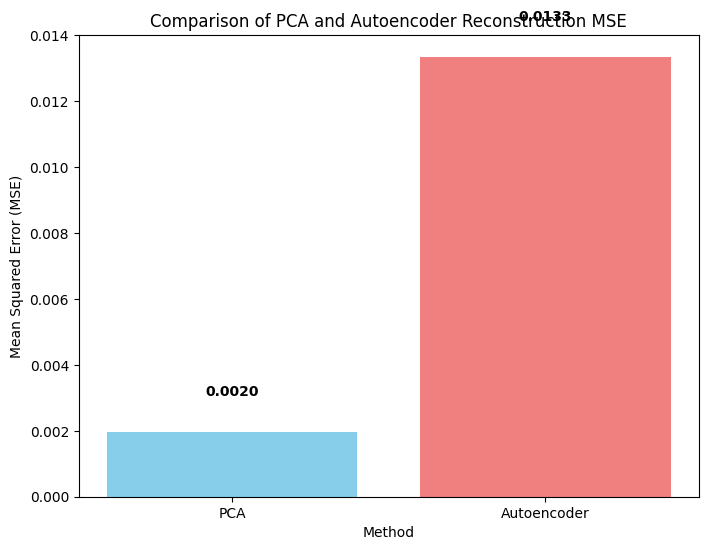

In [36]:
mse_values = [pca_mse, autoencoder_mse]
labels = ['PCA', 'Autoencoder']
plt.figure(figsize=(8, 6))
plt.bar(labels, mse_values, color=['skyblue', 'lightcoral'])
plt.xlabel('Method')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of PCA and Autoencoder Reconstruction MSE')

for i, v in enumerate(mse_values):
    plt.text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.show()

<hr>